In [1]:
%config Completer.use_jedi = False

https://www.kaggle.com/nixiam/credit-card-fraud-detection-autoencoder

# AutoEncoder : self learning and anomaly detection for Credit Card Fraud Detection
   
   
***Self-reconstruction by manifold learning***  
이 노트북은 AutoEncoder을 이용하여 분석했다는 것에 초점을 둔다. 그 중에서도 AutoEncoder의 특성중 하나인 manifold learning을 이용한다. Manifold learning은 학습하고자하는 고차원의 Database를 저차원 공간의 manifold 위로 mapping 하여 관계성을 찾는 것을 말한다. 만약 학습하고자 하는 DB가 매끄러운 manifold를 잘 형성하고 각 데이터가 manifold 위의 한 점으로 mapping 될 수 있다면 encoder는 이 작업을 원활하게 수행할 수 있다. 하지만 Dataspace상에서 encoder가 잘 mapping할 수 없는 영역의 data가 주어지는 경우 decoder로 해석할 수 있는 매끄러운 manifold에 mapping되지 않고 이는 데이터의 심한 왜곡을 동반하게 된다. 이렇게 학습된 DB의 특성에 가까운 데이터를 잘 복원해 내는 능력을 자기복원 능력이라고 한다.  
  
***Anomaly Detection with self-reconstruction***  
이번 노트북에서는 AutEncoder의 자기복원능력을 다룬다는 사실이 중요하다. (이 다음에 다뤄볼 노트북에서는 semi-supervised learning을 통한 저차원 표현에 관해서 다뤄볼 것이다.) 자기복원 능력이 잘 학습된 모델일 수록 원하는 DB의 페턴에 해당하는 데이터는 손실이나 왜곡없이 복원해 내고 그렇지 않은 즉 abnormal data는 심한 왜곡을 동반한다. 모델을 통과하기 전의 자신으로부터 얼마나 달라졌는지를 확인하는 reconstruction loss를 측정하고 적절한 elbow point를 문턱값으로 설정함으로 관측된 데이터가 normal 한지 abnormal 한지 알아낼 수 있다. 원문서의 작성자는 AutoEncoder를 불균형한 데이터를 이용하여 아주 소수의 Fraud data를 abnormal 하다고 가정하고 문제를 풀이한다. 하지만 몇가지 납득되지 않는 부분들도 있어서 그런 부분들만 내 식으로 수정하여서 따라가 보도록 하였다.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


사실 나는 딥러닝을 시작으로 머신러닝에 입문하였고 일반적인 머신러닝의 한계점들을 극복하면서 딥러닝이 등장했다고 알고있었기 때문에 일반적인 데이터 분석에서 딥러닝만 뚝딱하면 원하는 모델이 딱뚝 학습될 것이라고 막연하게 생각하고 있었다. 하지만 캐글에 입문하여 여러 고수 형님들의 코드를 보고 내가 아는 데이터 분석, 머신러닝은 정말 새발의 피 정도 된다는 것을 느꼈다. 심지어 머신러닝은 쓰지도 않고 원하는 모델링을 수학적으로 해내는 사람들도 있었다. 그래서 캐글을 시작하기 전에는 이렇게 간만에 tensorflow를 보게될 줄 몰랐다. 오랜만에 보니 반갑다.

In [3]:
# 사용 가능한 GPU 찾는 부분은 생략

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

Fully connected layer들을 이용해서 병목을 만들고 거기서 표현되는 차원들을 들여다 볼 것이다. 필요한 패키지들을 불러왔다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 여기까지 import 끝

In [5]:
df = pd.read_csv('../data/creditcard.csv')

# 앞으로는 소수점 아래 4자리까지만 보자.
#pd.options.display.float_format = "{:.4f}".format

좋은거 배웠다. 람다 형식으로 함수 자체를 지정해버리는 스킬인듯 하다. 나중에 더 찾아볼것. 하지만 여기서는 쓰지 않는다.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

여기서 알 수 있는 정보는 다음과 같다.  
- null 값이 없는 이상적인 데이터다.  
- Class를 제외한 모든 데이터가 float64로 통일되어있다.  
- Time과 Amount 를 제외한 모든 데이터가 float64로 통일되어있다.
- Vn 으로 표시된 열들은 서로 어떤 관련성이 있는지 유추할 수 있는 정보가 없다.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


여기서 알 수 있는 정보는 다음과 같다.
- Time 과 Amount는 Vn데이터들에 비해 분산이 매우 크다.
- Vn으로 표시된 데이터들은 평균이 모두 0이다.
- Class의 1은 전체 데이터에서 0.17% 정도 밖에 안된다.

일반적인 경우라고 한다면 Time과 Amount를 비슷한 scale로 맞춰주는 작업을 하고 어떤 이상한 값, 예컨데 굉장히 크거나 작은 값, 등을 제거할지 말지 따져보거나 resample 과정을 거치거나 하는 작업을 해 줄 것이다. 하지만 원 문서의 작성자는 이 데이터에서 Time 만을 제외하고 그냥 AutoEncoder에 때려 넣어 버린다. 그런데 이 부분은 조금 실수라고 보이는게 제외해야하는 열은 Class이기 때문이다. 원작자는 iloc을 사용했는데 내가 iloc을 잘 안쓰는 이유가 여기에 있다. 나는 Class를 버리고 학습을 시켜보도록 하겠다.  
우선 anomaly detecting을 위해서는 모델이 normal data의 manifold를 완전하게 학습해야한다. 여기서는 압도적인 수의 데이터가 Class == 0 이기 때문에 사기가 아닌 데이터들의 manifold를 학습하도록 해준다. 그리고 검증을 위해서 Class == 1 인 데이터의 수 만큼의 undersample을 구해서 검증해주도록 하자.

In [8]:
no_fraud = df[df["Class"] == 0]
fraud = df[df["Class"] == 1]

print(len(no_fraud), len(fraud))

284315 492


In [9]:
val_no_fraud = no_fraud.sample(len(fraud))
no_fraud = no_fraud.drop(val_no_fraud.index)

print(len(no_fraud), len(val_no_fraud))

283823 492


In [10]:
val_df = pd.concat([val_no_fraud,fraud], axis = 0)
val_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
56116,47277.0,-3.252003,-3.532797,0.871696,2.174637,2.138990,-1.381614,-0.078863,-0.054862,-0.088663,...,0.008449,1.277569,3.387570,0.130370,-0.487031,-0.315806,0.509318,-0.364241,82.52,0
208597,137190.0,1.852831,-1.196914,-0.598625,-0.761814,-0.894869,-0.022569,-0.855861,0.088688,2.105732,...,-0.005906,-0.072495,0.098256,-1.031017,-0.517607,0.582690,-0.037713,-0.034977,122.68,0
108980,71162.0,1.398061,-1.080751,0.808499,-1.295701,-1.695448,-0.621343,-1.114116,-0.069780,-1.785930,...,-0.306512,-0.537256,0.230660,0.358823,0.011981,-0.403387,0.056954,0.033496,33.00,0
281250,170031.0,-0.844178,1.650760,-1.542955,-0.505270,0.427950,-0.496311,0.376109,0.772779,-0.458977,...,0.352951,0.903308,-0.247697,-1.131456,-0.304274,-0.104345,0.095053,0.149414,40.50,0
43808,41660.0,0.633407,-1.236188,0.868334,0.387877,-1.022153,0.981145,-0.637737,0.457291,0.922759,...,0.007049,-0.234539,-0.066256,-0.220000,-0.140257,0.930089,-0.048764,0.036770,236.72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [11]:
# Shuffle
val_df = val_df.sample(len(val_df))

In [12]:
from sklearn.preprocessing import StandardScaler

StandardScaler의 설명을 보면 각 feature에 대한 mean과 std를 구한 후 mean으로 빼고 std로 나누어 준다고 되어있다. Vn 데이터의 경우 std를 1로 맞춰주려는 것이고 Amount의 경우는 둘 다 해주려는 것이다.

In [13]:
ssc = StandardScaler()

In [14]:
# 원 문서에서는 iloc을 이용하지만 여기서는 내가 더 선호하는 방식으로 바꿔서 작성했다.
X = no_fraud.drop("Class",axis = 1)
X = ssc.fit_transform(X)
print(df.shape)
print(X.shape)
print(X[0])

(284807, 31)
(283823, 30)
[-1.99728755 -0.70889603 -0.04059462  1.72937943  0.99032468 -0.25334831
  0.34573969  0.19513304  0.08582861  0.32975513  0.07754832 -0.54343669
 -0.66460364 -0.99644675 -0.36027672  1.60440969 -0.56539376  0.2621408
  0.02652165  0.49902899  0.32739366 -0.02385521  0.3840073  -0.17783659
  0.11003306  0.2469814  -0.39191175  0.33484615 -0.06343469  0.24507324]


이렇게 30개의 feature로 구성된 데이터들이 완성되었다. 이제 이 녀석을 self-supervised learning으로 학습하여 확실히 majority 가 있는 패턴을 복원하도록 훈련할 것이다. 지금은 Vn으로 라벨이 가려진 Feature에 대해서 한정적인 접근밖에 할 수 없으므로 일반적인 통계를 이용하는 것보다 훨씬 쉽게 문제를 풀 수 있는 장점이 있다.

In [15]:
num_of_feature = X.shape[1]

input_tensor = Input( [num_of_feature] )
x = Dense(64, activation = 'relu')(input_tensor)
x = Dense(32, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
output_tensor = Dense(num_of_feature)(x)

AutoEncoder = Model(input_tensor, output_tensor)

In [16]:
# 원작자는 adam을 따로 호출해 준 것을 볼 수 있는데 
# 아마 learning rate을 조절하기 위함인듯 하다.
# 여기서는 좀 더 쉽게 그냥 가본다.
#adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
AutoEncoder.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['mse'], # 원 문서에서는 accuracy를 사용한다. 하지만 후처리를 해주지 않았기 때문에 acc는 아무 의미가 없다.
)
AutoEncoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
Total params: 8,126
Trainable params: 8,126
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

In [18]:
training_history = AutoEncoder.fit(
    x=X,
    y=X,
    batch_size=2048, # 원작자는 2064를 썼는데 왜 그렇게 했는지 잘 모르겠다..
    epochs=200,
    verbose=1,
    callbacks=[callback],
    validation_split=0.1, # validation data로 10%의 데이터를 추출한다. -> val_loss 측정
    shuffle=True,
)

Epoch 1/200
125/125 [==============================] - 1s 3ms/step - loss: 0.8347 - mse: 0.8347 - val_loss: 0.2771 - val_mse: 0.2771
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1755 - mse: 0.1755 - val_loss: 0.0871 - val_mse: 0.0871
Epoch 3/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - 

In [19]:
print(training_history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


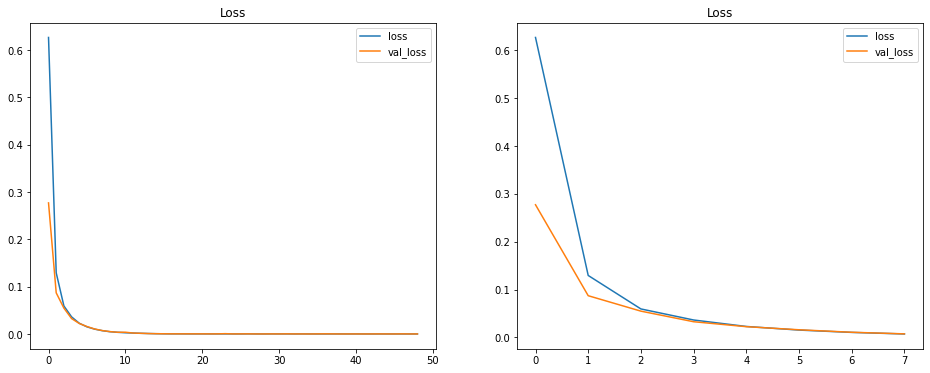

In [20]:
fig, ax = plt.subplots(1, 2, figsize=[16, 6])

ax[0].plot(training_history.history['loss'])
ax[0].plot(training_history.history['val_loss'])
ax[0].set_title("Loss")
ax[0].legend(['loss','val_loss'])

zoom_range = 8
ax[1].plot(training_history.history['loss'][:zoom_range])
ax[1].plot(training_history.history['val_loss'][:zoom_range])
ax[1].set_title("Loss")
ax[1].legend(['loss','val_loss'])

plt.show()

3 epoch 만에 수렴한 것을 알 수 있다. 이제 이 모델이 얼마나 majority pattern에 대한 복원력이 강력한지 평가해보자. 

In [21]:
val_X = ssc.transform(val_df.drop("Class", axis = 1))
val_X.shape

(984, 30)

In [22]:
val_prediction = AutoEncoder.predict(val_X)
mse = np.mean( (val_prediction - val_X) ** 2 , axis = 1)
mse.shape

(984,)

In [23]:
val_reconst_loss = pd.DataFrame({'mse' : mse})
val_reconst_loss

,mse
0,0.000010
1,0.271334
2,0.000070
3,0.000015
4,0.000054
...,...
979,0.000015
980,0.000029
981,0.000014
982,0.000039


In [25]:
val_reconst_loss.describe()

,mse
count,984.000000
mean,0.312107
std,1.085730
min,0.000008
25%,0.000023
50%,0.000072
75%,0.159827
max,9.171434


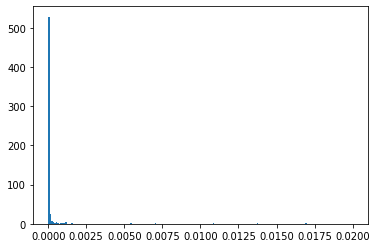

In [51]:
vrl = val_reconst_loss["mse"].to_numpy()
_bins = 200
end = 1
hist, bins, _ = plt.hist(
    vrl,
    bins = _bins,
    range = [vrl.min(), 0.02]
)
plt.show()

In [52]:
threshold = 0.0025
threshold

0.0025

In [53]:
val_reconst_loss["Prediction"] = 1
val_reconst_loss.loc[val_reconst_loss["mse"] < threshold, "Prediction"] = 0
val_reconst_loss

,mse,Prediction
0,0.000010,0
1,0.271334,1
2,0.000070,0
3,0.000015,0
4,0.000054,0
...,...,...
979,0.000015,0
980,0.000029,0
981,0.000014,0
982,0.000039,0


In [55]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [56]:
y = val_df["Class"].to_numpy()
pred = val_reconst_loss["Prediction"].to_numpy()
print(y.shape == pred.shape)

True


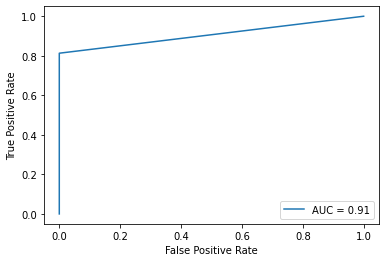

In [57]:
fpr, tpr, thresholds = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()

In [58]:
from sklearn.metrics import accuracy_score

In [59]:
accuracy_score(y,pred)

0.9065040650406504